# [Mood] Data Collection 

The MTG-Jamendo Dataset contains over 55,000 full audio tracks with 195 tags from genre, instrument, and mood/theme categories. A subset of this dataset focusing on mood/theme tags is also provided which includes 18,486 audio tracks with mood and theme annotations. In total, there are 59 tags, and tracks can possibly have more than one tag. 

Due to ressources limitations, I [downloaded](https://repositori.upf.edu/bitstream/handle/10230/42015/bogdanov_ICML2019__Jamendo.pdf?sequence=1&isAllowed=y) 992 tracks out of 18,486. We'll call it MTG-Jamendo Autotagging Mood Theme Subset.

In [1]:
import os
import csv
import json
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
JAMENDO_PATH = '/home/elise/Downloads/mtg-jamendo-dataset-master/'
METADATA_PATH = JAMENDO_PATH + 'data/'
AUDIO_ROOT_PATH = JAMENDO_PATH + 'audios/' 
TAGS_PATH = METADATA_PATH + 'tags/' 

DATA_PATH = '../data/'
MELSPECS_DIR = DATA_PATH + 'mood-melspecs-4544/'
SPLITS_DIR = DATA_PATH + 'mood-splits/'

# 1. Loading Metadata

In [3]:
# Saving relative paths of a subset of MTG-Jamendo Autotagging Mood Theme Dataset
all_filenames = []
for dirpath, dirnames, filenames in os.walk(AUDIO_ROOT_PATH):
    if not dirnames:
        subdir = dirpath.split('/')[-1]
        for fn in filenames:
            all_filenames.append(subdir + '/' + fn)

print(f'Number of tracks: {len(all_filenames)}')
print(all_filenames[:5])  

Number of tracks: 992
['04/1288104.mp3', '04/1164204.mp3', '04/1394904.mp3', '04/1287604.mp3', '04/1195904.mp3']


In [4]:
TRACK_ID_IDX = 0
PATH_IDX = 3
DURATION_IDX = 4
TAGS_IDX = 5

metadata = []

with open(METADATA_PATH + 'autotagging_moodtheme.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')

    for i, line in enumerate(reader):

        if line[PATH_IDX] in all_filenames:

            # Collecting the relevant information and adding it to metadata
            track_id = line[TRACK_ID_IDX]
            path = line[PATH_IDX]
            duration = line[DURATION_IDX]
            tags = [tag[13:] for tag in line[TAGS_IDX:]] # 'mood/theme---dark' => 'dark' 
            metadata.append([track_id, path, duration, tags])

In [5]:
df_metadata = pd.DataFrame(metadata, columns=['track_id', 'mp3_path', 'duration', 'tags'])

print(df_metadata.shape)
df_metadata.head()

(992, 4)


,track_id,mp3_path,duration,tags
0,track_0007400,00/7400.mp3,146.1,[drama]
1,track_0007401,01/7401.mp3,132.1,[drama]
2,track_0012100,00/12100.mp3,198.3,"[energetic, heavy]"
3,track_0012101,01/12101.mp3,237.4,"[energetic, heavy]"
4,track_0012102,02/12102.mp3,202.5,"[energetic, heavy]"


In [6]:
# Expand filename of `df_metadata`
df_metadata['mp3_path'] = AUDIO_ROOT_PATH + '/' + df_metadata.mp3_path

# Converting duration values into float
df_metadata['duration'] = df_metadata['duration'].astype(float)

In [7]:
# Create tags Series
tracks_tags = df_metadata.tags

# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# One-hot encode data
one_hot_tags = mlb.fit_transform(tracks_tags)

# View classes
all_tags = mlb.classes_
all_tags

array(['action', 'adventure', 'advertising', 'ambiental', 'background',
       'ballad', 'calm', 'children', 'christmas', 'commercial', 'cool',
       'corporate', 'dark', 'deep', 'documentary', 'drama', 'dramatic',
       'dream', 'emotional', 'energetic', 'epic', 'fast', 'film', 'fun',
       'funny', 'game', 'groovy', 'happy', 'heavy', 'holiday', 'hopeful',
       'horror', 'inspiring', 'love', 'meditative', 'melancholic',
       'mellow', 'melodic', 'motivational', 'movie', 'nature', 'party',
       'positive', 'powerful', 'relaxing', 'retro', 'romantic', 'sad',
       'sexy', 'slow', 'soft', 'soundscape', 'space', 'sport', 'summer',
       'trailer', 'travel', 'upbeat', 'uplifting'], dtype=object)

In [8]:
# Converting `one_hot_tags` to a dataframe
df_one_hot_tags = pd.DataFrame(one_hot_tags, columns=all_tags)
df_one_hot_tags

,action,adventure,advertising,ambiental,background,ballad,calm,children,christmas,commercial,...,slow,soft,soundscape,space,sport,summer,trailer,travel,upbeat,uplifting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Inspecting Metadata

In [9]:
all_tags

array(['action', 'adventure', 'advertising', 'ambiental', 'background',
       'ballad', 'calm', 'children', 'christmas', 'commercial', 'cool',
       'corporate', 'dark', 'deep', 'documentary', 'drama', 'dramatic',
       'dream', 'emotional', 'energetic', 'epic', 'fast', 'film', 'fun',
       'funny', 'game', 'groovy', 'happy', 'heavy', 'holiday', 'hopeful',
       'horror', 'inspiring', 'love', 'meditative', 'melancholic',
       'mellow', 'melodic', 'motivational', 'movie', 'nature', 'party',
       'positive', 'powerful', 'relaxing', 'retro', 'romantic', 'sad',
       'sexy', 'slow', 'soft', 'soundscape', 'space', 'sport', 'summer',
       'trailer', 'travel', 'upbeat', 'uplifting'], dtype=object)

## 2.1. Deleting theme tags

In [10]:
theme_tags = ['action', 'adventure', 'advertising', 'background', 'children', 'commercial', 'corporate', 'documentary', 'drama', 'dramatic', 'epic', 'fast', 'film', 'game', 'movie', 'nature', 'soundscape', 'space','trailer']

In [11]:
for tag in theme_tags:

    # Dropping the column corresponding to `tag`
    df_one_hot_tags.drop(tag, axis=1, inplace=True)

    # Deleting the tag in the column `tags` of `df_metadata`
    for track_tags in df_metadata.tags:
        if tag in track_tags:
            track_tags.remove(tag)

    # Updating the list of labels
    all_tags = np.delete(all_tags, np.where(all_tags == tag))

In [12]:
len(all_tags)

40

## 2.2. Merging Synonyms

In [13]:
# Creating list of synonyms
synonyms = ['fun', 'funny']

# Dropping the column corresponding to the second word in `synonym`
merged_values = df_one_hot_tags[synonyms].sum(axis=1).clip(upper=1)
df_one_hot_tags.drop(synonyms[1], axis=1, inplace=True)
df_one_hot_tags[synonyms[0]] = merged_values.values

# Replacing each synonym by one word
df_metadata.tags = [[synonyms[0] if tag == synonyms[1] else tag for tag in tags] for tags in df_metadata.tags]

# Updating the `all_tags` array
all_tags = np.delete(all_tags, np.where(all_tags == synonyms[1]))

In [14]:
len(all_tags)

39

## 2.3. Removing Less Frequent Tags

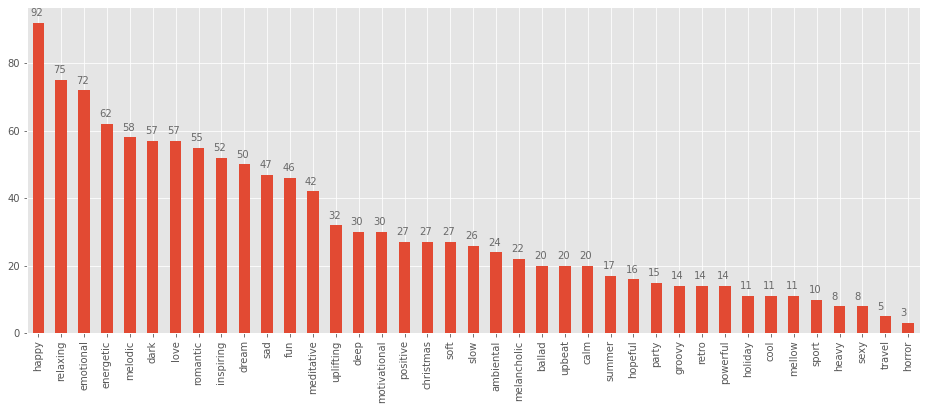

In [15]:
# Plotting tags frequencies
ax = df_one_hot_tags.sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(16,6))
for i in ax.patches:
    ax.text(x=i.get_x() - 0.1, y=i.get_height() + 2, s=str(i.get_height()), fontsize=10, color='dimgrey')

In [16]:
# Displaying the number of tracks for some tags
print(f"Happy: { np.sum(df_one_hot_tags['happy']) }")
print(f"Travel: { np.sum(df_one_hot_tags['travel']) }")
print(f"Horror: { np.sum(df_one_hot_tags['horror']) }")

Happy: 92
Travel: 5
Horror: 3


In [17]:
# FInding tags where the number of tracks < 10
tags_to_remove = all_tags[np.sum(df_one_hot_tags[all_tags]) < 10]
tags_to_remove

array(['heavy', 'horror', 'sexy', 'travel'], dtype=object)

In [18]:
# Removing tags where the number of tracks < 10
for tag in tags_to_remove:

    # Dropping the column corresponding to `tag`
    df_one_hot_tags.drop(tag, axis=1, inplace=True)

    # Deleting the tag in the column `tags` of `df_metadata`
    for track_tags in df_metadata.tags:
        if tag in track_tags:
            track_tags.remove(tag)

    # Updating the list of labels
    all_tags = np.delete(all_tags, np.where(all_tags == tag))

In [19]:
len(all_tags)

35

## 2.4. Merging Metadata and One-Hot Encoded Tags 

In [17]:
# Re-ordering columns by name
df_one_hot_tags = df_one_hot_tags.reindex(sorted(df_one_hot_tags.columns), axis=1)

# Merging metadata and one_hot encoded tags
df_complete_metadata = pd.concat([df_metadata, df_one_hot_tags], axis=1)

# Removing tracks where tags is empty
df_complete_metadata = df_complete_metadata[np.sum(df_complete_metadata.iloc[:, 4:], axis=1) != 0]

# Reseting the index
df_complete_metadata = df_complete_metadata.reset_index(drop=True)
df_complete_metadata

,track_id,mp3_path,duration,tags,ambiental,ballad,calm,christmas,cool,dark,...,relaxing,retro,romantic,sad,slow,soft,sport,summer,upbeat,uplifting
0,track_0012100,/home/elise/Downloads/mtg-jamendo-dataset-mast...,198.3,[energetic],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,track_0012101,/home/elise/Downloads/mtg-jamendo-dataset-mast...,237.4,[energetic],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,track_0012102,/home/elise/Downloads/mtg-jamendo-dataset-mast...,202.5,[energetic],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,track_0012303,/home/elise/Downloads/mtg-jamendo-dataset-mast...,331.9,[retro],0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,track_0013400,/home/elise/Downloads/mtg-jamendo-dataset-mast...,204.9,[ballad],0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,track_1420604,/home/elise/Downloads/mtg-jamendo-dataset-mast...,194.0,[deep],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
795,track_1420700,/home/elise/Downloads/mtg-jamendo-dataset-mast...,182.9,"[deep, happy]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
796,track_1420701,/home/elise/Downloads/mtg-jamendo-dataset-mast...,214.5,"[fun, happy, romantic]",0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
797,track_1420702,/home/elise/Downloads/mtg-jamendo-dataset-mast...,181.0,"[deep, happy, romantic]",0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [18]:
# Storing complete metadata
filepath = DATA_PATH + 'mood_metadata_labels.csv'
df_complete_metadata.to_csv(filepath)

np.save(DATA_PATH + 'mood_all_tags.npy', all_tags)

# 3. Preparing Mel Spectrograms Inputs for Deep Neural Networks

## 3.1. Audio Metadata Analysis

__Labels Repartition__

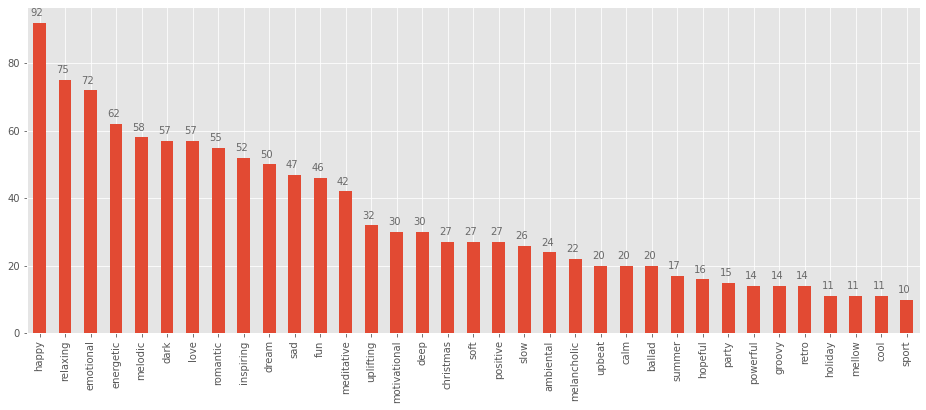

In [41]:
# Updated: Plotting tags frequencies
ax = df_complete_metadata.iloc[:, 4:].sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(16,6))
for i in ax.patches:
    ax.text(x=i.get_x() - 0.1, y=i.get_height() + 2, s=str(i.get_height()), fontsize=10, color='dimgrey')

__Audios Duration__

In [47]:
print(np.min(df_complete_metadata['duration']))
print(np.max(df_complete_metadata['duration']))

30.0
1766.0


__Number of Samples and Sampling Rate__

In [51]:
audio_metadata = []

for i, row in tqdm(df_complete_metadata.iterrows(), desc='Progress'):
    
    # Loading audio data
    y, sr = librosa.core.load(row.mp3_path, sr=None)
    audio_metadata.append([len(y), sr])

Progress: 799it [17:12,  1.29s/it]


In [52]:
audio_metadata = pd.DataFrame(audio_metadata, columns=["length", "samplerate"])
audio_metadata.describe()

,length,samplerate
count,7.990000e+02,799.000000
mean,9.637983e+06,44329.411765
std,6.232701e+06,918.221846
min,1.322898e+06,44100.000000
25%,6.363958e+06,44100.000000
50%,8.792662e+06,44100.000000
75%,1.142210e+07,44100.000000
max,7.788060e+07,48000.000000


__Observations:__

    1. A disproportionate ratio of audios in each class which is problematic since most machine learning algorithms work best when the number of samples are balanced through each category
    2. Tracks don't have the same duration
    3. Audio files have different number of samples
    4. Audio files have different sample rate 
    

## 3.2. Data Augmentation Strategy with a Multiframe Approach



[Original paper](https://repositori.upf.edu/bitstream/handle/10230/42015/bogdanov_ICML2019__Jamendo.pdf?sequence=1&isAllowed=y) used 29.1s of each track as in [Choi et al.](https://arxiv.org/pdf/1606.00298.pdf) and computed a log-amplitude mel spectrogram using 96 mel-bins and a hop size of 256 samples. I will follow the same parameters settings except for the `hop_length`.

Since the whole songs are available, I can adopt a multiframe strategy that allows me to extract more than one frame (or mel-spectrograms image) per song. For each song, I discard the first and last 20 seconds (empirically non-representative of the song content most of the time), then divide the rest into non-overlapping frames of equal time-length 29.1s. Since the songs are of different duration, the last frame is removed if its duration is lower than 29.1s. Downsampled to 12kHz as suggested in Choi et al.

Finally, the number of frames will be variable. We will se at the end how many frames we will keep to get a semi-balanced dataset of mel-spectrograms.

In [19]:
SAMPLE_RATE = 12000
SEGMENT_DURATION = 29.1 # seconds
SAMPLES_PER_SEGMENT = SAMPLE_RATE * SEGMENT_DURATION # Here: 349 200

MAX_SIZE_MELSPEC = (96, 341)
MIN_DURATION = SEGMENT_DURATION + 40

In [20]:
melspecs_filenames_list = []
one_hot_labels_list = []
melspecs_metadata = []

for i, row in tqdm(df_complete_metadata.iterrows(), desc='Progress'):
    
    track_id = row['mp3_path'].split('/')[-1]
    one_hot_labels = list(row[4:].values)

    audio_duration = row.duration

    if audio_duration >= MIN_DURATION:
        loading_duration = audio_duration - 40
        num_segments = int(loading_duration / SEGMENT_DURATION)

        # Loading audio data
        y, sr = librosa.load(row.mp3_path, sr=SAMPLE_RATE, offset=20, duration=loading_duration)
    else:
        num_segments = int(audio_duration / SEGMENT_DURATION)

        # Loading audio data
        y, sr = librosa.load(row.mp3_path, sr=SAMPLE_RATE)

    # Processing segments, extracting mel spectrograms and storing data
    for s in range(num_segments):
        start_sample = int(SAMPLES_PER_SEGMENT * s)
        finish_sample = int(start_sample + SAMPLES_PER_SEGMENT)
        
        # Time-frequency transformation with mel-scaling
        melspec = librosa.feature.melspectrogram(y=y[start_sample:finish_sample], 
                                                sr=sr, 
                                                n_fft=2048, 
                                                hop_length=1024,
                                                n_mels=96)
        
        # Transforming to decibel scale
        melspec = librosa.power_to_db(melspec, ref=np.max)
        
        # Re-shaping to final segment size
        if melspec.shape != MAX_SIZE_MELSPEC:
            melspec.resize(MAX_SIZE_MELSPEC)

        # Saving the mel spectrogram into a .npy file
        npy_filename = track_id.replace('.mp3', f'.{s}.melspec.npy')
        np.save(MELSPECS_DIR + npy_filename, melspec)

        melspecs_filenames_list.append(npy_filename)
        one_hot_labels_list.append(one_hot_labels)
        melspecs_metadata.append([npy_filename] + one_hot_labels)

Progress: 799it [2:02:34,  9.20s/it]


In [21]:
melspecs_filenames_arr_path = DATA_PATH + 'mood_melspecs_filenames.npy'
one_hot_labels_arr_path = DATA_PATH + 'mood_one_hot_labels.npy'
melspecs_metadata_df_path = DATA_PATH + 'mood_melspecs_metadata.csv'

In [22]:
# Converting to arrays 
melspecs_filenames_arr = np.array(melspecs_filenames_list)
one_hot_labels_arr = np.array(one_hot_labels_list)

# Saving the data
np.save(melspecs_filenames_arr_path, melspecs_filenames_arr)
np.save(one_hot_labels_arr_path, one_hot_labels_arr)

columns = ['filename'] + list(all_tags)
df_melspecs_metadata = pd.DataFrame(melspecs_metadata, columns=columns)
df_melspecs_metadata.to_csv(melspecs_metadata_df_path)

## 3.3. Setting train, validation, and test sets
Dealing with imbalanced datasets. [Two resampling methods](
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18):
- Oversample minority classes
- Undersample majority classes

In [23]:
# Loading data
X_filenames = np.load(melspecs_filenames_arr_path)
one_hot_y = np.load(one_hot_labels_arr_path)
df_melspecs_metadata = pd.read_csv(melspecs_metadata_df_path)

In [24]:
df_melspecs_metadata = df_melspecs_metadata.iloc[:, 1:]
df_melspecs_metadata

,filename,ambiental,ballad,calm,christmas,cool,dark,deep,dream,emotional,...,relaxing,retro,romantic,sad,slow,soft,sport,summer,upbeat,uplifting
0,12100.0.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12100.1.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12100.2.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12100.3.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12100.4.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,1420702.3.melspec.npy,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4540,1420704.0.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4541,1420704.1.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4542,1420704.2.melspec.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def decoder(y_instance, label_map):
    idx = [i for i, value in enumerate(y_instance) if value == 1]
    tags = [v for k, v in label_map.items() if k in idx]
    return tags

def plot_tags_repartition(y, label_map, title):
    occ = defaultdict(int)
    for instance in y:
        tags = decoder(instance, label_map)
        for tag in tags:
            occ[tag] += 1

    df_occ = pd.DataFrame.from_dict(occ, orient='index', columns=['frequency']).sort_index(axis=0)

    # Plot
    ax = df_occ.sort_values(by='frequency', ascending=False).plot(kind='bar', figsize=(16,6), title=title)
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(x=i.get_x() - 0.15, y=i.get_height() + 10, s=str(i.get_height()), fontsize=10, color='dimgrey')

    return df_occ

### Base Split

In [26]:
def train_val_test_split(X, y, train_size, random_state=42):
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, train_size=0.5, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [27]:
X_train_filenames, X_val_filenames, X_test_filenames, one_hot_y_train, one_hot_y_val, one_hot_y_test = train_val_test_split(X_filenames, one_hot_y, train_size=0.8)

In [28]:
print(X_train_filenames.shape, one_hot_y_train.shape)
print(X_val_filenames.shape, one_hot_y_val.shape)
print(X_test_filenames.shape, one_hot_y_test.shape)

(3635,) (3635, 35)
(454,) (454, 35)
(455,) (455, 35)


In [29]:
np.save(SPLITS_DIR + 'base/X_train_filenames', X_train_filenames)
np.save(SPLITS_DIR + 'base/X_val_filenames', X_val_filenames)
np.save(SPLITS_DIR + 'base/X_test_filenames', X_test_filenames)
np.save(SPLITS_DIR + 'base/one_hot_y_train', one_hot_y_train)
np.save(SPLITS_DIR + 'base/one_hot_y_val', one_hot_y_val)
np.save(SPLITS_DIR + 'base/one_hot_y_test', one_hot_y_test)

In [30]:
X_train_filenames = np.load(SPLITS_DIR + 'base/X_train_filenames.npy')
one_hot_y_train = np.load(SPLITS_DIR + 'base/one_hot_y_train.npy')

In [31]:
# Loading the label map
with open(DATA_PATH + 'mood_label_map.json', 'r') as output:
    label_map = json.load(output)

inv_label_map = {v: k for k, v in label_map.items()}

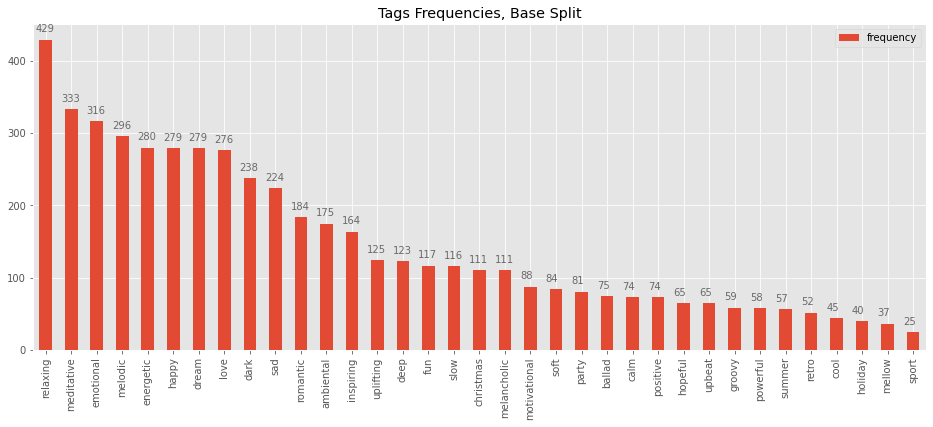

In [32]:
df_occ_base_split = plot_tags_repartition(one_hot_y_train, inv_label_map, 'Tags Frequencies, Base Split')

### Method 1 — Oversample minority classes

In [33]:
MAX_TAGS_FREQ = np.max(df_occ_base_split['frequency'])
MAX_TAGS_FREQ

429

In [34]:
def upsampling(X_train, y_train, upsampling_size, all_tags=all_tags, df_occurrences=df_occ_base_split, label_map=label_map, random_state=42):
    """ 
    
    Arguments:
        upsampling_size {float [0,1]} -- the proportion of the maximum frequency tag to match (? approx)
    """


    X_train_upsampled, y_train_upsampled = [], []


    # Computing the number of samples to match 
    n_samples = int(MAX_TAGS_FREQ * upsampling_size)
    print('\n\nn_samples:', n_samples)
    
    # Separating minority and majority classes
    minority_classes = all_tags[df_occurrences['frequency'] < n_samples]
    majority_classes = all_tags[df_occurrences['frequency'] >= n_samples]
    print('Minority classes:', minority_classes)
    print('Majority classes:', majority_classes)

    # Gathering mel spectrograms of majority
    
    majority_mask = y_train[:, label_map[majority_classes[0]]] == 1 # First mask
    for majority_class in majority_classes[1:]:
        majority_mask = majority_mask | y_train[:, label_map[majority_class]] == 1 # avec le ou, je controle overlapping

    X_majority = X_train[majority_mask] # numpy
    y_majority = y_train[majority_mask] # numpy

    X_train_upsampled.extend(X_majority)
    y_train_upsampled.extend(y_majority)


    # Upsampling minority
    mask_unique_labels = np.sum(y_train, axis=1) == 1
    
    for minority_class in minority_classes:

        # Selecting songs (or mel spectrograms) with `minority_class` tag
        current_class_mask = y_train[:, label_map[minority_class]] == 1
        X_current_class_tmp = X_train[current_class_mask & mask_unique_labels]
        y_current_class_tmp = y_train[current_class_mask & mask_unique_labels]
        if len(X_current_class_tmp) == 0:
            X_current_class_tmp = X_train[current_class_mask]
            y_current_class_tmp = y_train[current_class_mask]

        X_current_class_upsampled, y_current_class_upsampled = resample(X_current_class_tmp, y_current_class_tmp,
                                                                        replace=True, # sample with replacement
                                                                        n_samples=n_samples, # match number of the min in majority class
                                                                        random_state=random_state) # reproducible results

        X_train_upsampled.extend(X_current_class_upsampled)
        y_train_upsampled.extend(y_current_class_upsampled)

    return X_train_upsampled, y_train_upsampled
    

In [35]:
def save_npy(X, y, method, proportion, save_path):
    X_name = f'X_train_filenames_{method}_{proportion}'
    y_name = f'one_hot_y_train_{method}_{proportion}'
    
    np.save(save_path + X_name, X)
    np.save(save_path + y_name, y)

In [36]:
sizes = [0.25, 0.5, 0.75, 1]

for size in sizes:
    X_train_filenames_upsample, one_hot_y_train_upsample = upsampling(X_train_filenames, one_hot_y_train, upsampling_size=size)
    save_npy(X_train_filenames_upsample, one_hot_y_train_upsample, method='upsample', proportion=str(size), save_path=SPLITS_DIR+'upsampling/')



n_samples: 107
Minority classes: ['ballad' 'calm' 'cool' 'groovy' 'holiday' 'hopeful' 'mellow'
 'motivational' 'party' 'positive' 'powerful' 'retro' 'soft' 'sport'
 'summer' 'upbeat']
Majority classes: ['ambiental' 'christmas' 'dark' 'deep' 'dream' 'emotional' 'energetic'
 'fun' 'happy' 'inspiring' 'love' 'meditative' 'melancholic' 'melodic'
 'relaxing' 'romantic' 'sad' 'slow' 'uplifting']


n_samples: 214
Minority classes: ['ambiental' 'ballad' 'calm' 'christmas' 'cool' 'deep' 'fun' 'groovy'
 'holiday' 'hopeful' 'inspiring' 'melancholic' 'mellow' 'motivational'
 'party' 'positive' 'powerful' 'retro' 'romantic' 'slow' 'soft' 'sport'
 'summer' 'upbeat' 'uplifting']
Majority classes: ['dark' 'dream' 'emotional' 'energetic' 'happy' 'love' 'meditative'
 'melodic' 'relaxing' 'sad']


n_samples: 321
Minority classes: ['ambiental' 'ballad' 'calm' 'christmas' 'cool' 'dark' 'deep' 'dream'
 'emotional' 'energetic' 'fun' 'groovy' 'happy' 'holiday' 'hopeful'
 'inspiring' 'love' 'melancholic' 'me

### Method 2 — Undersample majority classes

In [37]:
MIN_TAGS_FREQ = np.min(df_occ_base_split['frequency'])
MINORITY_CLASS = 'sport'

In [38]:
def downsampling(X_train, y_train, downsampling_size, all_tags=all_tags, df_occurrences=df_occ_base_split, label_map=label_map, random_state=42):
    """ 
    
    Arguments:
        downsampling_size {float [0,1]} -- de combien de % reduit on la difference entre le tag actuel et le minority class

        Example:
            downsampling_size = 0.5
            number of samples in minority class = 25
            number of samples in another class = 100
            diff = 100 - 25 = 75

            downsample the other class of diff * downsampling_size = 75 * 0.5 = 37 (np.ceil)
            --> on reduit de 37, cad qu'on passe de 100 à 100 - 37 = 63 
    """

    X_train_downsampled, y_train_downsampled = [], []



    # Gathering mel spectrograms filenames of minority class
    minority_mask = y_train[:, label_map[MINORITY_CLASS]] == 1
    
    X_minority = X_train[minority_mask] # numpy
    y_minority = y_train[minority_mask] # numpy
    
    X_train_downsampled.extend(X_minority)
    y_train_downsampled.extend(y_minority)
    


    # Downsampling majority classes
    mask_unique_labels = np.sum(y_train, axis=1) == 1

    for current_class in all_tags:

        if current_class != MINORITY_CLASS:
            n_samples_in_current_class = df_occurrences.loc[current_class, 'frequency']
            n_samples_to_match = int(np.ceil((n_samples_in_current_class - MIN_TAGS_FREQ) * (1-downsampling_size)))

            if n_samples_to_match < MIN_TAGS_FREQ:
                n_samples_to_match = MIN_TAGS_FREQ

            #print(n_samples_in_current_class, n_samples_to_match)

            current_class_mask = y_train[:, label_map[current_class]] == 1

            X_current_class_tmp = X_train[current_class_mask & mask_unique_labels]
            y_current_class_tmp = y_train[current_class_mask & mask_unique_labels]
            if len(X_current_class_tmp) == 0:
                X_current_class_tmp = X_train[current_class_mask]
                y_current_class_tmp = y_train[current_class_mask]
            

            if len(X_current_class_tmp) < n_samples_to_match:
                X_current_class_downsampled, y_current_class_downsampled = resample(X_current_class_tmp, y_current_class_tmp,
                                                                        replace=True, # sample with replacement
                                                                        n_samples=n_samples_to_match, # match minority
                                                                        random_state=random_state) # reproducible results
 
            else:
                X_current_class_downsampled, y_current_class_downsampled = resample(X_current_class_tmp, y_current_class_tmp,
                                                                        replace=False, # sample without replacement
                                                                        n_samples=n_samples_to_match, # match minority
                                                                        random_state=random_state) # reproducible results


            X_train_downsampled.extend(X_current_class_downsampled)
            y_train_downsampled.extend(y_current_class_downsampled)

            
    # Converting to an array
    X_train_downsampled = np.array(X_train_downsampled)
    y_train_downsampled = np.array(y_train_downsampled)

    return X_train_downsampled, y_train_downsampled
    

In [39]:
for size in sizes:
    X_train_filenames_downsample, one_hot_y_train_downsample = downsampling(X_train_filenames, one_hot_y_train, downsampling_size=size)
    save_npy(X_train_filenames_downsample, one_hot_y_train_downsample, method='downsample', proportion=str(size), save_path=SPLITS_DIR+'downsampling/')